# XGboost classifier with ROC and precision-recall

## import libraries

In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_recall_curve, precision_score, f1_score, recall_score, roc_auc_score, roc_curve, auc 
import itertools
import xgboost as xgb


## Creation of functions 

### Code for T/F-N/P

In [2]:
# TP = confusion_matrix[0,0]
# FP = confusion_matrix[1,0]  
# FN = confusion_matrix[0,1]
# TN = confusion_matrix[1,1]

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)

# # Overall accuracy
# ACC = (TP+TN)/(TP+FP+FN+TN)

### Confusion matrice function

In [3]:
# confusion matrix function

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

### ROC curve function

In [4]:
def plot_roc_curve(labels, predictions, positive_label=1, num_thresh_points=10, thresholds_step=0.2, title=''):
    # fp: false positive rates. tp: true positive rates
    i=0
    fp, tp, thresholds = roc_curve(labels, predictions, pos_label=positive_label)
    thresholdsLength = len(thresholds)
    num_thresh_points = int(np.linspace(0,thresholdsLength,num_thresh_points)[1].round(0))-1
    colorMap=plt.get_cmap('rainbow', thresholdsLength)
    roc_auc = auc(fp, tp)

    plt.figure(figsize=(12, 12))
    plt.plot(fp, tp, label='ROC curve (area = %0.3f)' % roc_auc, linewidth=0, color='red')
    plt.plot([0, 1], [0, 1], label='No skill', color='navy', linestyle='--', linewidth=2)
    plt.text(0.8, 0.2, 'ROC curve (area = %0.3f)' % roc_auc, fontdict={'size': 1}, color=colorMap(thresholdsLength));
    plt.xlabel('False positives rate', fontsize=12)
    plt.ylabel('True positives rate', fontsize=12)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title(title, fontsize=16)
    plt.grid(True)

    for x, y, txt in zip(fp[1::num_thresh_points], tp[1::num_thresh_points], thresholds[1::num_thresh_points]):
        i+=1
        plt.annotate(np.round(txt,2), (x, y-0.04))
        plt.scatter(x, y, s=12, color=colorMap(num_thresh_points*i/thresholdsLength))
        if i <=1:
            plt.plot(fp[0:num_thresh_points+1], tp[0:num_thresh_points+1], label='high threshold', linewidth=2, color=colorMap(0))
            plt.plot(fp[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], tp[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], linewidth=2, color=colorMap(num_thresh_points*i/thresholdsLength))
        elif i == num_thresh_points-4:
            plt.plot(fp[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], tp[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], label='low threshold', linewidth=2, color=colorMap(num_thresh_points*i/thresholdsLength))

        else:
            plt.plot(fp[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], tp[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], linewidth=2, color=colorMap(num_thresh_points*i/thresholdsLength))
    
#     # This code is for having exact values of thresholds (0.1,0.3,0.5,0.7, and 0.9) but won't work if these values are not in the threshold list
#     for decim in np.arange(0.9,0.0,-thresholds_step):
#         index = np.where(thresholds.round(1) == decim)
#         print('index', len(index[0]))
#         print('thresholds', thresholds)
#         if len(index[0])==0: 
#             pass
#         else :
#             threshold_value_with_max_four_decimals = str(thresholds[index[0][0]].round(1))
#             plt.text(fp[index[0][0]] - 0.03, tp[index[0][0]] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 12}, color=colorMap(index[0][0]/thresholdsLength));
#             plt.scatter(fp[index[0][0]], tp[index[0][0]], s=8, color=colorMap(index[0][0]/thresholdsLength))
#             if decim >=0.9:
#                 plt.plot(fp[0:index[0][0]], tp[0:index[0][0]], label='high threshold (>=0.9)', linewidth=2, color=colorMap(0))
#                 plt.plot(fp[index[0][0]:np.where(thresholds.round(3) == (decim-thresholds_step))[0][0]], tp[index[0][0]:np.where(thresholds.round(3) == (decim-thresholds_step))[0][0]], linewidth=2, color=colorMap(index[0][0]/thresholdsLength))
#             elif decim <=0.1:
#                 plt.plot(fp[index[0][0]: thresholdsLength], tp[index[0][0]:thresholdsLength], label='low threshold (<=0.1)', linewidth=2, color=colorMap(index[0][0]/thresholdsLength))
#             else : 
#                 plt.plot(fp[index[0][0]:np.where(thresholds.round(3) == (decim-thresholds_step))[0][0]], tp[index[0][0]:np.where(thresholds.round(3) == (decim-thresholds_step))[0][0]], linewidth=2, color=colorMap(index[0][0]/thresholdsLength))

    plt.legend(loc="lower right")
    plt.show()

### Precision-recall curve function

In [5]:
def plot_precision_recall_curve(labels, predictions, positive_label=1, num_thresh_points=10, thresholds_step=0.2, title=''):
    # Precision : TP amongst all PREdicted positive (TP+FP), Recall: TP amongst all REal positive (TP+FN)
    i=0
    precision, recall, thresholds = precision_recall_curve(labels, predictions, pos_label=positive_label)
    thresholdsLength = len(thresholds)
    num_thresh_points = int(np.linspace(0,thresholdsLength,num_thresh_points)[1].round(0))-1
    colorMap=plt.get_cmap('rainbow', thresholdsLength)
    precision_recall_auc = auc(recall, precision)

    plt.figure(figsize=(12, 12))
    plt.plot(recall, precision, label='Precision-recall curve (area = %0.3f)' % precision_recall_auc, linewidth=0, color='red')
    plt.plot([0, 1], [0, 0], label='No skill', color='navy', linestyle='--', linewidth=2)
    plt.text(0.8, 0.2, 'ROC curve (area = %0.3f)' % precision_recall_auc, fontdict={'size': 1}, color=colorMap(thresholdsLength));
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title(title, fontsize=16)
    plt.grid(True)

    for x, y, txt in zip(recall[1::num_thresh_points], precision[1::num_thresh_points], thresholds[1::num_thresh_points]):
        i+=1
        plt.annotate(np.round(txt,2), (x, y-0.04))
        plt.scatter(x, y, s=12, color=colorMap(num_thresh_points*i/thresholdsLength))
        if i <=1:
            plt.plot(recall[0:num_thresh_points+1], precision[0:num_thresh_points+1], label='high threshold', linewidth=2, color=colorMap(0))
            plt.plot(recall[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], precision[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], linewidth=2, color=colorMap(num_thresh_points*i/thresholdsLength))
        elif i == num_thresh_points-5:
            plt.plot(recall[(num_thresh_points*i)+1:thresholdsLength], precision[(num_thresh_points*i)+1:thresholdsLength], label='low threshold', linewidth=2, color=colorMap(num_thresh_points*i/thresholdsLength))

        else:
            plt.plot(recall[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], precision[(num_thresh_points*i)+1:(num_thresh_points*(i+1))+(i+1)], linewidth=2, color=colorMap(num_thresh_points*i/thresholdsLength))

    
#     # This code is for having exact values of thresholds (0.1,0.3,0.5,0.7, and 0.9) but won't work if these values are not in the threshold list
#     for decim in np.arange(0.9,0.0,-thresholds_step):
#         index = np.where(thresholds.round(3) == decim)
#         threshold_value_with_max_four_decimals = str(thresholds[index[0][0]].round(1))
#         plt.text(precision[index[0][0]] - 0.03, recall[index[0][0]] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 12}, color=colorMap(index[0][0]/thresholdsLength));
#         plt.scatter(precision[index[0][0]], recall[index[0][0]], s=8, color=colorMap(index[0][0]/thresholdsLength))
#         if decim >=0.9:
#             plt.plot(precision[0:index[0][0]], recall[0:index[0][0]], label='high threshold (>=0.9)', linewidth=2, color=colorMap(0))
#             plt.plot(precision[index[0][0]:np.where(thresholds.round(3) == (decim-thresholds_step))[0][0]], recall[index[0][0]:np.where(thresholds.round(3) == (decim-thresholds_step))[0][0]], linewidth=2, color=colorMap(index[0][0]/thresholdsLength))

    
#         elif decim <=0.1:
#             plt.plot(precision[index[0][0]: thresholdsLength], recall[index[0][0]:thresholdsLength], label='low threshold (<=0.1)', linewidth=2, color=colorMap(index[0][0]/thresholdsLength))

            
#         else : 
#             plt.plot(precision[index[0][0]:np.where(thresholds.round(3) == (decim-thresholds_step))[0][0]], recall[index[0][0]:np.where(thresholds.round(3) == (decim-thresholds_step))[0][0]], linewidth=2, color=colorMap(index[0][0]/thresholdsLength))

    plt.legend(loc="lower right")
    plt.show()

## Data preparation

load and prepare data

In [6]:
#load the data
Ktrain = pd.read_csv('./data/titanic/train.csv')

In [7]:
#Ktrain.head(3)

In [8]:
train = Ktrain[['Survived', 'Sex', 'Age']]
train = train.dropna(axis=0)

In [9]:
train.isna().sum()

Survived    0
Sex         0
Age         0
dtype: int64

In [10]:
train.Survived.value_counts()

0    424
1    290
Name: Survived, dtype: int64

In [11]:
#train.head(3)

In [12]:
x_train= train[['Sex', 'Age']]

In [13]:
x_train['Sex'] = np.where((x_train.Sex == 'male'), 0.0,1.0)

<ipython-input-13-cdab1f63aa32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Sex'] = np.where((x_train.Sex == 'male'), 0.0,1.0)


In [14]:
x_train.head(3)

,Sex,Age
0,0.0,22.0
1,1.0,38.0
2,1.0,26.0


In [15]:
y_train= ~train['Survived']+2 # use for inverting 0 and 1. Now 1 is 'deceased and 0 is 'survived'

In [16]:
y_train.value_counts()

1    424
0    290
Name: Survived, dtype: int64

## Model building and prediction 

Logistic regression : building a simple model with only 2 features

In [17]:
# Set regularization rate
reg = 0.01

classifier = LogisticRegression(C=1/reg, solver="liblinear")
Logmodel = classifier.fit(x_train,y_train)

In [18]:
y_proba = Logmodel.predict_proba(x_train) # soft class predictions (proba)
y_score = Logmodel.predict(x_train) # hard class predictions (0 : survived ; 1 : deceased)

In [19]:
#y_proba[:,1] #1 probability deceased

XGboost : building a simple model with only 2 features

In [44]:
def model(classifier):

    # Define preprocessing for numerical columns 
    # Standardize features by removing the mean and scaling to unit variance

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # Define preprocessing for categorical features and encode categorical features as a one-hot numeric array.

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', classifier)])

    # fit the pipeline to train a logistic regression model on the training set
    model = pipeline.fit(x_train, y_train)
    #print (model)

    # Get predictions from test data
    predictions = model.predict(x_train)
    y_scores = model.predict_proba(x_train)

    cm = confusion_matrix(y_train, predictions)
    #print ('Confusion Matrix:\n',cm, '\n')
    print('Accuracy:', accuracy_score(y_train, predictions))
    print('Classification Report:', classification_report(y_train, predictions))

    plot_confusion_matrix(cm, classes = ['survived', 'dead'])
    plt.show()
    return 

In [27]:
from sklearn.pipeline import Pipeline

In [29]:
from sklearn.preprocessing import StandardScaler

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
from sklearn.compose import ColumnTransformer

In [45]:
numeric_features = ['Age']
categorical_features = ['Sex']

In [48]:
y_train

0      1
1      0
2      0
3      0
4      1
      ..
885    1
886    1
887    0
889    0
890    1
Name: Survived, Length: 714, dtype: int64

Accuracy: 0.819327731092437
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.74      0.77       290
           1       0.83      0.87      0.85       424

    accuracy                           0.82       714
   macro avg       0.82      0.81      0.81       714
weighted avg       0.82      0.82      0.82       714



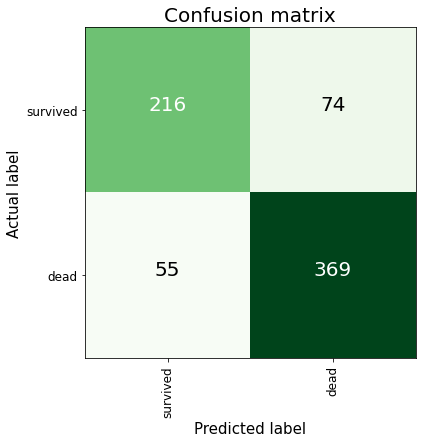

In [50]:
model(xgb.XGBClassifier(max_depth=20, use_label_encoder=False, eval_metric='logloss'))

In [67]:
from sklearn.preprocessing import MultiLabelBinarizer


In [70]:
mlb = MultiLabelBinarizer()
# y_multilabel = mlb.fit_transform(list([y_train]))
y_multilabel = mlb.fit_transform([{'sci-fi', 'thriller'}, {'comedy'}])
y_multilabel

array([[0, 1, 1],
       [1, 0, 0]])

In [71]:
y_multilabel.shape

(2, 3)

In [72]:
y_multilabel

array([[0, 1, 1],
       [1, 0, 0]])

In [62]:
list([y_train])

[0      1
 1      0
 2      0
 3      0
 4      1
       ..
 885    1
 886    1
 887    0
 889    0
 890    1
 Name: Survived, Length: 714, dtype: int64]

## Model evaluation

### Confusion matrices and performance score

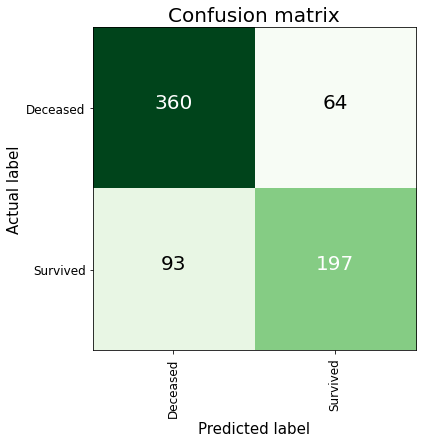

In [53]:
# confusion matrix
confusionMTX = confusion_matrix(y_train, y_score, labels=[1, 0]) 

TP = confusionMTX[0,0]
FP = confusionMTX[1,0]  
FN = confusionMTX[0,1]
TN = confusionMTX[1,1]

# Fall out or false positive rate
FPR = FP/(FP+TN)

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = ['Deceased', 'Survived'])

In [54]:
print(classification_report(y_train, y_score))

              precision    recall  f1-score   support

           0       0.75      0.68      0.72       290
           1       0.79      0.85      0.82       424

    accuracy                           0.78       714
   macro avg       0.77      0.76      0.77       714
weighted avg       0.78      0.78      0.78       714



### ROC curve with threshold values visualization

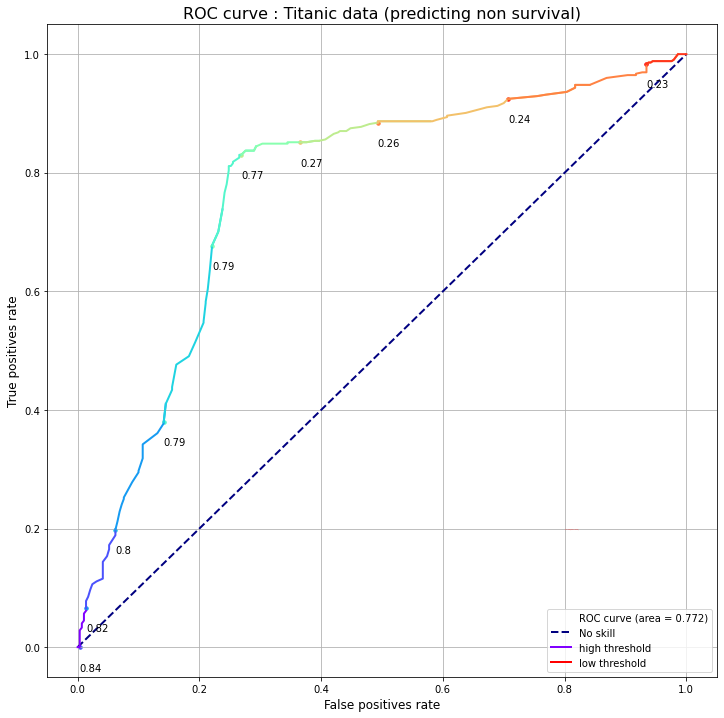

In [55]:
plot_roc_curve(y_train, y_proba[:,1], title='ROC curve : Titanic data (predicting non survival)')

### Precision-recall curve with threshold values visualization

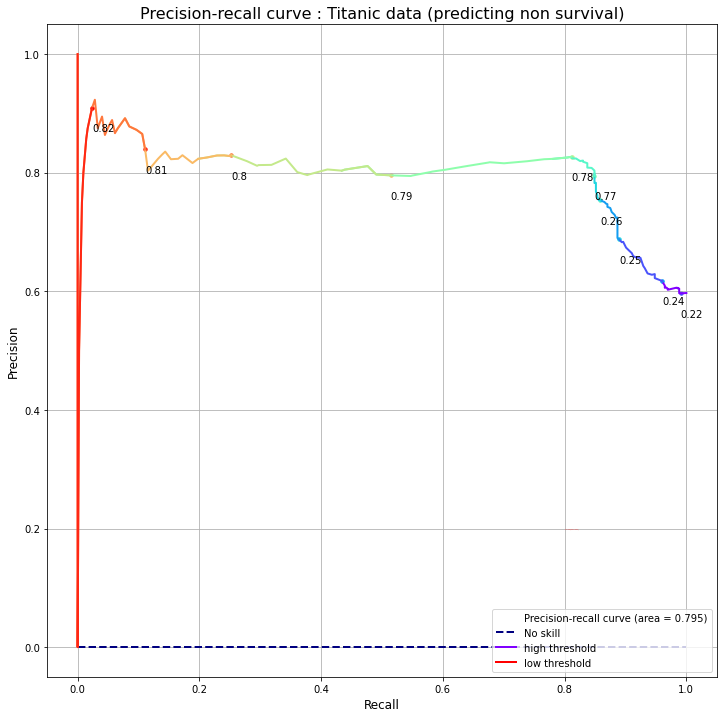

In [83]:
plot_precision_recall_curve(y_train, y_proba[:,1], title='Precision-recall curve : Titanic data (predicting non survival)')

### Confusion matrices and performance score for thresholds between 0.0 to 1.0

In [199]:
def set_threshold(score, threshold):
#    print(threshold)
    return 1.0 if score >= threshold else 0.0

Use this line to change the threshold for the probability to have deceased : 0.0, all passengers survived ; 0.0, all passengers deceased:
- According to the ROC and Precision-recall curves, best threshold = 0.77 

In [204]:
y_score_thres = np.array([set_threshold(proba, 0.77) for proba in y_proba[:,1]])

ROC scores:
True positive rate: 0.84
False positive rate: 0.28

Precision-recall scores:
Precision: 0.82
Recall: 0.84

Accuracy: 0.79


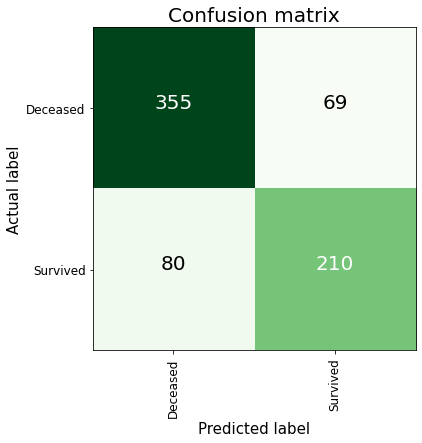

In [205]:
# confusion matrix
confusionMTX = confusion_matrix(y_train,y_score_thres, labels=[1, 0]) 

TP = confusionMTX[0,0]
FP = confusionMTX[1,0]  
FN = confusionMTX[0,1]
TN = confusionMTX[1,1]

# Fall out or false positive rate
FPR = FP/(FP+TN)

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = ['Deceased', 'Survived'])

# print ROC and precision recall score 
print('ROC scores:')
print("True positive rate:",recall_score(y_train,y_score_thres).round(2))
print("False positive rate:",FPR.round(2))
print('')
print('Precision-recall scores:')
print("Precision:",precision_score(y_train, y_score_thres).round(2))
print("Recall:",recall_score(y_train, y_score_thres).round(2))
print('')
print("Accuracy:",accuracy_score(y_train, y_score_thres).round(2))